In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from cheyette.curves import FlatCurve
from cheyette.products import BondOpt, OptionType, ZCBCallAnnuity
from cheyette.processes import VasicekProcess, QuadraticAnnuityProcess
from cheyette.discretization import PeacemanRachford
from cheyette.boundary_conditions import DirichletIntrinsicBC
from cheyette.models import CheyettePDEModel, CheyetteAnalyticModel
from cheyette.pricers import CheyettePricer

plt.style.use('input/qulib.mplstyle')

# Bond option pricing

In [2]:
curve = FlatCurve(short_rate=0.01)
mean_rev = 0.01
local_vol = 0.02
process = VasicekProcess(mean_rev=mean_rev, local_vol=local_vol)
process_annuity = QuadraticAnnuityProcess(mean_rev, a=local_vol, b=0.0, c=0.0)

model_pde = CheyettePDEModel(x_grid_stddevs=5.0, y_grid_stddevs=5.0,
                    x_freq=3, y_freq=3, t_freq=10,
                    stepping_method=PeacemanRachford(),
                    x_lower_bc=DirichletIntrinsicBC(), x_upper_bc=DirichletIntrinsicBC(),
                    y_lower_bc=DirichletIntrinsicBC(), y_upper_bc=DirichletIntrinsicBC())

model_analytic = CheyetteAnalyticModel()

strike = 0.98
expiry = 10.00
bond_expiry = 20.00
product = BondOpt(strike=strike, expiry=expiry, bond_expiry=bond_expiry, option_type=OptionType.call)
product_annuity = ZCBCallAnnuity(strike=strike, expiry=expiry, bond_expiry=bond_expiry,
                                 curve=curve, process=process_annuity)

valuation_time = 0.0
pricer_pde = CheyettePricer(model_pde, curve, process, product, valuation_time)
pricer_annuity = CheyettePricer(model_pde, curve, process_annuity, product_annuity, valuation_time)
pricer_analytic = CheyettePricer(model_analytic, curve, process, product, valuation_time)

notional = 10000.0

pv_pde = pricer_pde.price()['PV']*notional
pv_annuity = pricer_annuity.price()['PV']*notional
pv_analytic = pricer_analytic.price()['PV']*notional

print(f'PDE PV: {pv_pde}')
print(f'Annuity PV: {pv_annuity}')
print(f'Analytic PV: {pv_analytic}')
print(f'Abs. Error Annuity: {pv_annuity - pv_analytic}')

PDE PV: 1623.050145569949
Annuity PV: 1610.2516772430156
Analytic PV: 1600.9631118121265
Abs. Error Annuity: 9.288565430889093


In [30]:
short_rates = np.arange(-0.05, 0.0501, 0.01)
curves = [FlatCurve(r) for r in short_rates]
products_annuity = [ZCBCallAnnuity(strike=strike, expiry=expiry, bond_expiry=bond_expiry,
                                   curve=x, process=process_annuity) for x in curves]

pvs_curve_pde = [pricer_pde.set('curve', x).price()['PV']*notional for x in curves]
pvs_curve_annuity = [pricer_annuity.set('product', x).set('curve', y).price()['PV']*notional
                     for x, y in zip(products_annuity, curves)]
pvs_curve_analytic = [pricer_analytic.set('curve', x).price()['PV']*notional for x in curves]

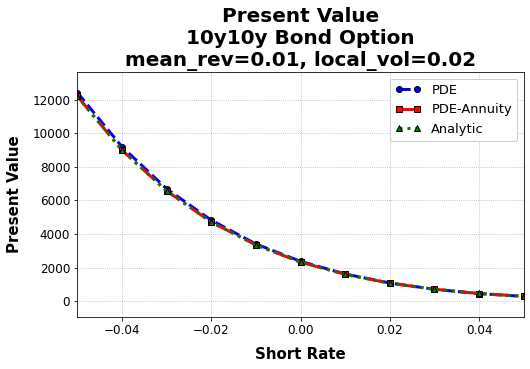

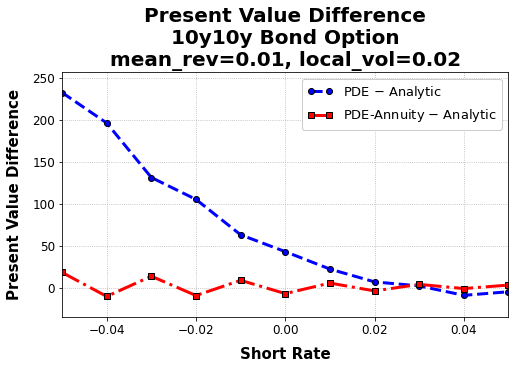

In [31]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, pvs_curve_pde, label='PDE')
ax.plot(short_rates, pvs_curve_annuity, label='PDE-Annuity')
ax.plot(short_rates, pvs_curve_analytic, label='Analytic')
ax.set_xlabel('Short Rate')
ax.set_ylabel('Present Value')
ax.set_title(f'Present Value\n'\
             f'{product.expiry:.0f}y{product.bond_expiry-product.expiry:.0f}y Bond Option\n'\
             f'mean_rev={process.mean_rev:.2f}, local_vol={process.local_vol:.2f}')
ax.legend()

diff_pde = [y - x for x, y in zip(pvs_curve_analytic, pvs_curve_pde)]
diff_annuity = [y - x for x, y in zip(pvs_curve_analytic, pvs_curve_annuity)]
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, diff_pde, label='PDE $-$ Analytic')
ax.plot(short_rates, diff_annuity, label='PDE-Annuity $-$ Analytic')
ax.set_xlabel('Short Rate')
ax.set_ylabel('Present Value Difference')
ax.set_title(f'Present Value Difference\n'\
             f'{product.expiry:.0f}y{product.bond_expiry-product.expiry:.0f}y Bond Option\n'\
             f'mean_rev={process.mean_rev:.2f}, local_vol={process.local_vol:.2f}')
ax.legend()